## Track Stocks in Excel

In [76]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
import os
from pathlib import Path
import pytz

In [77]:
# --- User Inputs ---
Stock_List = ['AAPL', 'NVDA', 'S59.SI', 'S58.SI']

sgtz = pytz.timezone("Asia/Singapore")
start_date = datetime(datetime.now().year - 5, datetime.now().month, datetime.now().day, tzinfo=sgtz)
end_date = datetime.now(sgtz)

# --- Folder setup ---
project_folder = Path.cwd() / "stock_data"
project_folder.mkdir(exist_ok=True)

# --- Main Loop ---
for stock in Stock_List:
    # =============================
    # DAILY DATA SECTION
    # =============================
    file_path = project_folder / f"{stock}_data_daily.csv"
    print(f"\n📆 Fetching Daily Data for {stock}...")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])
        last_date = df["Date"].iloc[-1] + timedelta(days=1)

        df_new = yf.download(
            stock,
            start=last_date,
            end=end_date,
            auto_adjust=False,
            group_by="columns"
        )

        if df_new.empty:
            print(f"⚠️ No new daily data for {stock}")
        else:
            if isinstance(df_new.columns, pd.MultiIndex):
                df_new.columns = [col[-1] for col in df_new.columns.values]

            df_new = df_new.reset_index()
            # daily uses "Date"
            if "Date" not in df_new.columns:
                df_new.rename(columns={df_new.columns[0]: "Date"}, inplace=True)

            df_new["Date"] = pd.to_datetime(df_new["Date"], errors="coerce")

            df = pd.concat([df, df_new], ignore_index=True)
            df = df.drop_duplicates(subset=["Date"], keep="last")

            df["Year"] = df["Date"].dt.year
            df["Month"] = df["Date"].dt.month
            df["Day"] = df["Date"].dt.day

            df.to_csv(file_path, index=False)
            print(f"💾 Updated daily data for {stock} (last: {df['Date'].iloc[-1]:%Y-%m-%d})")

    else:
        print(f"⬇️ Downloading daily data for {stock} from scratch...")
        df = yf.download(
            stock,
            start=start_date,
            end=end_date,
            auto_adjust=False,
            group_by="columns"
        )

        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [col[-1] for col in df.columns.values]

        df = df.reset_index()
        if "Date" not in df.columns:
            df.rename(columns={df.columns[0]: "Date"}, inplace=True)

        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

        df["Year"] = df["Date"].dt.year
        df["Month"] = df["Date"].dt.month
        df["Day"] = df["Date"].dt.day

        df.to_csv(file_path, index=False)
        print(f"💾 Created daily data for {stock} (rows: {len(df)})")

    # =============================
    # INTRADAY DATA SECTION
    # =============================
    file_path = project_folder / f"{stock}_data_intraday.csv"
    print(f"\n🕒 Fetching Intraday Data for {stock}...")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

        # rebuild Datetime
        df["Datetime"] = pd.to_datetime(df[["Year", "Month", "Day", "Hour", "Minute", "Second"]])
        df["Datetime"] = df["Datetime"].dt.tz_localize("Asia/Singapore")

        last_date = df["Datetime"].iloc[-1] + timedelta(minutes=1)

        # --- ensure Yahoo's 7-day limit ---
        max_intraday_window = timedelta(days=7)
        if (end_date - last_date) > max_intraday_window:
            print(f"⏳ {stock}: Requested range > 7 days, adjusting start to 7 days ago.")
            start_intraday = end_date - max_intraday_window
        else:
            start_intraday = last_date

        df_new = yf.download(
            stock,
            start=start_intraday,
            end=end_date,
            interval="1m",
            auto_adjust=False,
            group_by="columns"
        )

        if df_new.empty:
            print(f"⚠️ No new intraday data for {stock}")
            continue

        if isinstance(df_new.columns, pd.MultiIndex):
            df_new.columns = [col[-1] for col in df_new.columns.values]

        df_new = df_new.reset_index()

        # --- intraday explicitly uses "Datetime"
        if "Datetime" not in df_new.columns:
            df_new.rename(columns={df_new.columns[0]: "Datetime"}, inplace=True)

        df_new["Datetime"] = pd.to_datetime(df_new["Datetime"], errors="coerce")

        # Convert to Singapore timezone (+08:00)
        if df_new["Datetime"].dt.tz is None:
            df_new["Datetime"] = df_new["Datetime"].dt.tz_localize("UTC").dt.tz_convert("Asia/Singapore")
        else:
            df_new["Datetime"] = df_new["Datetime"].dt.tz_convert("Asia/Singapore")

        df = pd.concat([df, df_new], ignore_index=True)
        df = df.drop_duplicates(subset=["Datetime"], keep="last")

        # Split into components for saving
        df["Year"] = df["Datetime"].dt.year
        df["Month"] = df["Datetime"].dt.month
        df["Day"] = df["Datetime"].dt.day
        df["Hour"] = df["Datetime"].dt.hour
        df["Minute"] = df["Datetime"].dt.minute
        df["Second"] = df["Datetime"].dt.second

        df.to_csv(file_path, index=False)
        print(f"💾 Updated intraday data for {stock} (last: {df['Datetime'].iloc[-1]})")

    else:
        print(f"⬇️ Downloading intraday data for {stock} from scratch...")

        # --- ensure Yahoo's 7-day limit for fresh downloads ---
        start_intraday = max(start_date, end_date - timedelta(days=7))

        df = yf.download(
            stock,
            start=start_intraday,
            end=end_date,
            interval="1m",
            auto_adjust=False,
            group_by="columns"
        )

        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [col[-1] for col in df.columns.values]

        df = df.reset_index()
        if "Datetime" not in df.columns:
            df.rename(columns={df.columns[0]: "Datetime"}, inplace=True)

        df["Datetime"] = pd.to_datetime(df["Datetime"], errors="coerce")

        # Convert to Singapore timezone (+08:00)
        if df["Datetime"].dt.tz is None:
            df["Datetime"] = df["Datetime"].dt.tz_localize("UTC").dt.tz_convert("Asia/Singapore")
        else:
            df["Datetime"] = df["Datetime"].dt.tz_convert("Asia/Singapore")

        df["Year"] = df["Datetime"].dt.year
        df["Month"] = df["Datetime"].dt.month
        df["Day"] = df["Datetime"].dt.day
        df["Hour"] = df["Datetime"].dt.hour
        df["Minute"] = df["Datetime"].dt.minute
        df["Second"] = df["Datetime"].dt.second

        df.to_csv(file_path, index=False)
        print(f"💾 Created intraday data for {stock} (rows: {len(df)})")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-10-11 04:00:00+08:00 -> 2025-10-12 17:35:15.542325+08:00)')



📆 Fetching Daily Data for AAPL...
💾 Updated daily data for AAPL (last: 2025-10-10)

🕒 Fetching Intraday Data for AAPL...
⚠️ No new intraday data for AAPL

📆 Fetching Daily Data for NVDA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-10-11 04:00:00+08:00 -> 2025-10-12 17:35:15.542325+08:00)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

💾 Updated daily data for NVDA (last: 2025-10-10)

🕒 Fetching Intraday Data for NVDA...
⚠️ No new intraday data for NVDA

📆 Fetching Daily Data for S59.SI...
💾 Updated daily data for S59.SI (last: 2025-10-10)

🕒 Fetching Intraday Data for S59.SI...




1 Failed download:
['S59.SI']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-10-10 17:00:00+08:00 -> 2025-10-12 17:35:15.542325+08:00)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['S58.SI']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-10-10 17:00:00+08:00 -> 2025-10-12 17:35:15.542325+08:00)')


⚠️ No new intraday data for S59.SI

📆 Fetching Daily Data for S58.SI...
💾 Updated daily data for S58.SI (last: 2025-10-10)

🕒 Fetching Intraday Data for S58.SI...
⚠️ No new intraday data for S58.SI


In [78]:
# Storing of all stock data into a dictionary for easy access
all_daily_stock_data = {}
all_intraday_stock_data = {}

for stock in Stock_List:
    file_path = project_folder / f"{stock}_data_daily.csv"
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])
    df = df.drop(['Year', 'Month', 'Day'], axis=1)
    all_daily_stock_data[stock] = df
    print(f"Loaded {len(df)} daily records for {stock}")
    
    file_path = project_folder / f"{stock}_data_intraday.csv"
    df = pd.read_csv(file_path)
    df["Datetime"] = pd.to_datetime(df[["Year", "Month", "Day", "Hour", "Minute", "Second"]])
    df["Datetime"] = df["Datetime"].dt.tz_localize("Asia/Singapore")
    df = df.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1)
    all_intraday_stock_data[stock] = df
    print(f"Loaded {len(df)} intraday records for {stock}")
    
    
    


Loaded 1256 daily records for AAPL
Loaded 1949 intraday records for AAPL
Loaded 1256 daily records for NVDA
Loaded 1949 intraday records for NVDA
Loaded 1258 daily records for S59.SI
Loaded 2585 intraday records for S59.SI
Loaded 1258 daily records for S58.SI
Loaded 3770 intraday records for S58.SI



📆 Plotting Past 1 Year Daily Data for AAPL (US)...


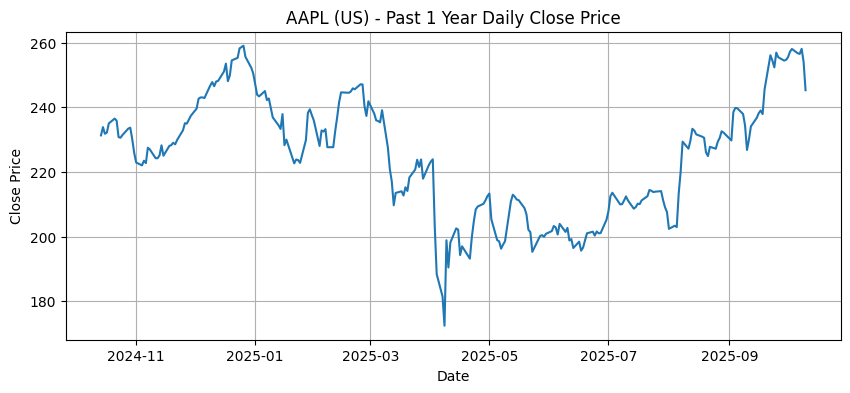


⏱ Plotting Intraday Data for AAPL (US) - 2025-10-10 (Last Full Day)...


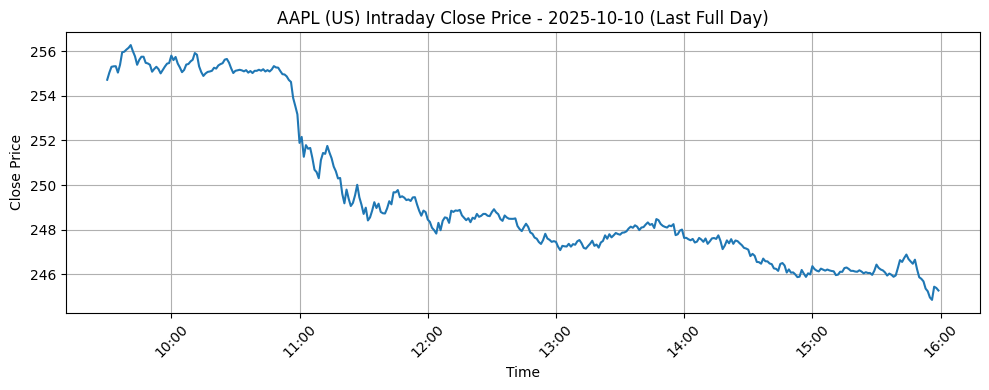


📆 Plotting Past 1 Year Daily Data for NVDA (US)...


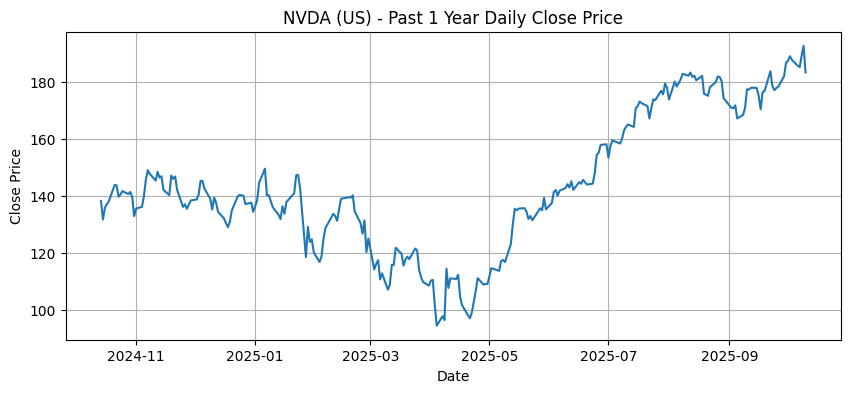


⏱ Plotting Intraday Data for NVDA (US) - 2025-10-10 (Last Full Day)...


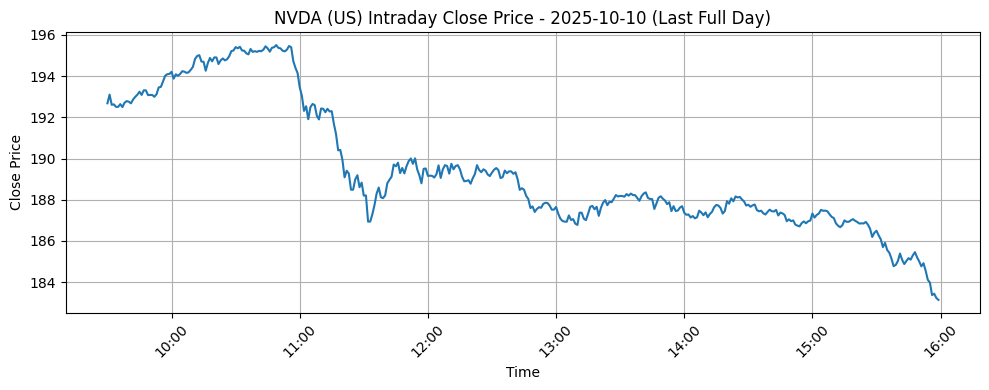


📆 Plotting Past 1 Year Daily Data for S59.SI (SG)...


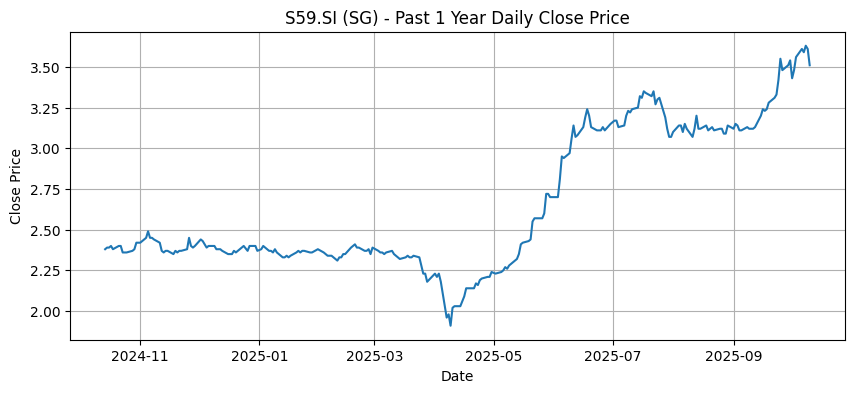


⏱ Plotting Intraday Data for S59.SI (SG) - 2025-10-10 (Last Full Day)...


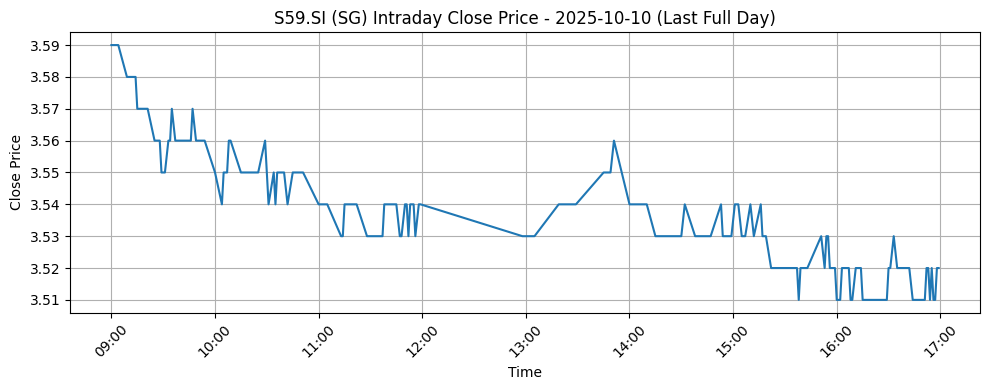


📆 Plotting Past 1 Year Daily Data for S58.SI (SG)...


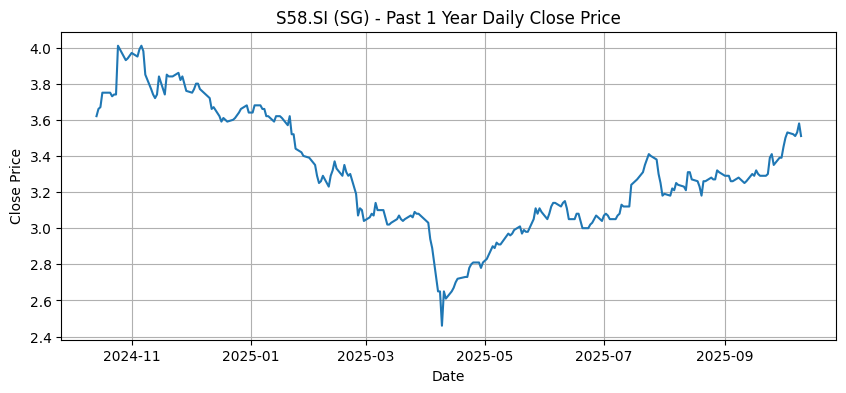


⏱ Plotting Intraday Data for S58.SI (SG) - 2025-10-10 (Last Full Day)...


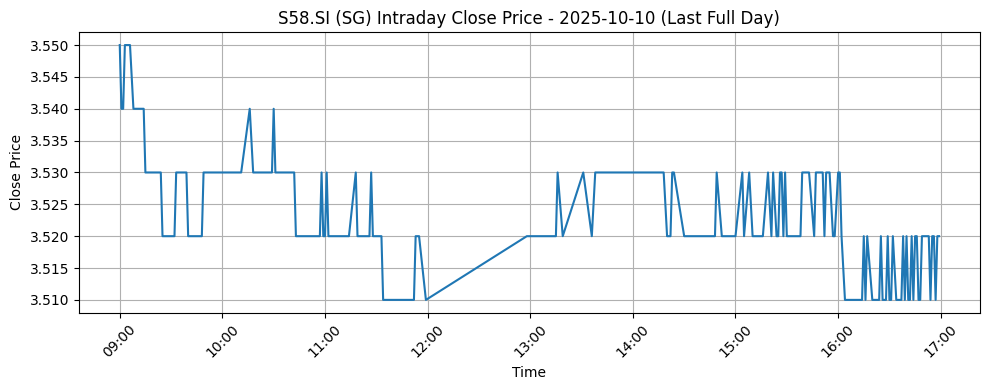

In [79]:
# --- Define your known timezones ---
TZ_MAP = {
    "SG": pytz.timezone("Asia/Singapore"),
    "US": pytz.timezone("US/Eastern")
}

def detect_market(stock):
    """Heuristic: detect market by suffix or known pattern"""
    if stock.endswith(".SI"):
        return "SG"
    else:
        return "US"

for stock in Stock_List:
    # --- Determine market timezone dynamically ---
    market = detect_market(stock)
    tz = TZ_MAP[market]

    # --- Generate time cutoffs relative to market timezone ---
    now_market = datetime.now(tz)
    one_year_ago = now_market - timedelta(days=365)
    today_date = now_market.date()

    # --- DAILY DATA SECTION ---
    filtered_daily_data = all_daily_stock_data[stock][
        all_daily_stock_data[stock]["Date"] >= one_year_ago.replace(tzinfo=None)
    ]

    print(f"\n📆 Plotting Past 1 Year Daily Data for {stock} ({market})...")
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=filtered_daily_data, x="Date", y="Close")
    plt.title(f"{stock} ({market}) - Past 1 Year Daily Close Price")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)
    plt.show()

    # --- INTRADAY DATA SECTION ---
    df_intra = all_intraday_stock_data[stock].copy()
    df_intra["DateOnly"] = df_intra["Datetime"].dt.tz_convert(tz).dt.date

    # Check if today's data exists in that timezone
    today_data = df_intra[df_intra["DateOnly"] == today_date]

    if not today_data.empty:
        filtered_intraday_data = today_data
        label = f"{today_date} (Today)"
    else:
        latest_date = df_intra["DateOnly"].max()
        filtered_intraday_data = df_intra[df_intra["DateOnly"] == latest_date]
        label = f"{latest_date} (Last Full Day)"

    print(f"\n⏱ Plotting Intraday Data for {stock} ({market}) - {label}...")
    
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=filtered_intraday_data, x="Datetime", y="Close")
    plt.title(f"{stock} ({market}) Intraday Close Price - {label}")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.grid(True)

    # Format X-axis to show hours and minutes
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=tz))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [80]:
# Correlation of stocks
# Initialize aligned DataFrames for each period
aligned_1_year = pd.DataFrame()
aligned_3_years = pd.DataFrame()
aligned_5_years = pd.DataFrame()


for stock in Stock_List:
    # --- Determine market timezone dynamically ---
    market = detect_market(stock)
    tz = TZ_MAP[market]

    # --- Generate time cutoffs relative to market timezone ---
    now_market = datetime.now(tz)
    one_year_ago = now_market - timedelta(days=365)
    three_years_ago = now_market - timedelta(days=3*365)
    five_years_ago = now_market - timedelta(days=5*365)
    six_months_ago = now_market - timedelta(days=182)

    # Select Date and Close only
    df = all_daily_stock_data[stock].copy()
    df = df[["Date", "Close"]]
    df["Date"] = pd.to_datetime(df["Date"])

    # Create filtered versions for each period
    df_1y = df[df["Date"] >= one_year_ago.replace(tzinfo=None)].set_index("Date").rename(columns={"Close": stock})
    df_3y = df[df["Date"] >= three_years_ago.replace(tzinfo=None)].set_index("Date").rename(columns={"Close": stock})
    df_5y = df[df["Date"] >= five_years_ago.replace(tzinfo=None)].set_index("Date").rename(columns={"Close": stock})

    # Outer join ensures all possible dates are included across stocks
    aligned_1_year = aligned_1_year.join(df_1y, how="outer")
    aligned_3_years = aligned_3_years.join(df_3y, how="outer")
    aligned_5_years = aligned_5_years.join(df_5y, how="outer")



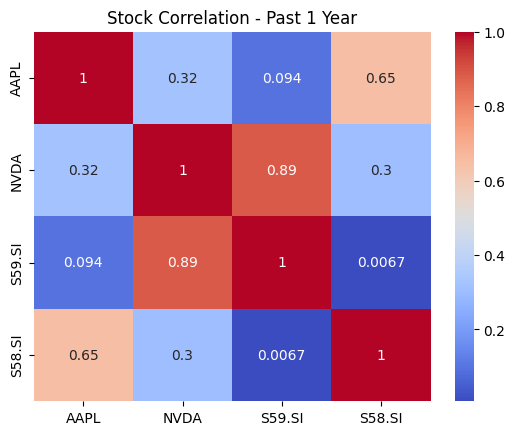

In [81]:
# Ensure Chrono order
aligned_1_year = aligned_1_year.sort_index().dropna()
aligned_3_years = aligned_3_years.sort_index().dropna()
aligned_5_years = aligned_5_years.sort_index().dropna()


#compute Correlation Matrices
corr_1_year = aligned_1_year.corr()
corr_3_years = aligned_3_years.corr()
corr_5_years = aligned_5_years.corr()

#plot Heatmaps
sns.heatmap(corr_1_year, annot=True, cmap="coolwarm")
plt.title("Stock Correlation - Past 1 Year")
plt.show()



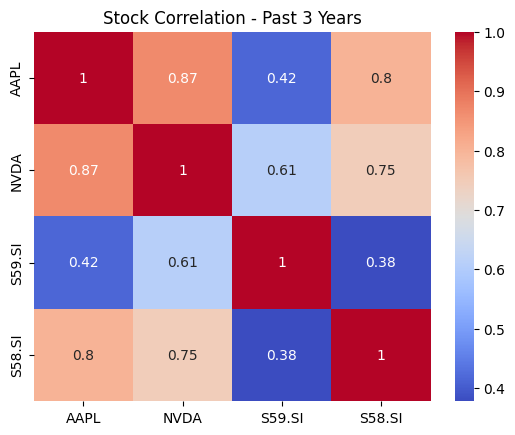

In [82]:
sns.heatmap(corr_3_years, annot=True, cmap="coolwarm")
plt.title("Stock Correlation - Past 3 Years")
plt.show()



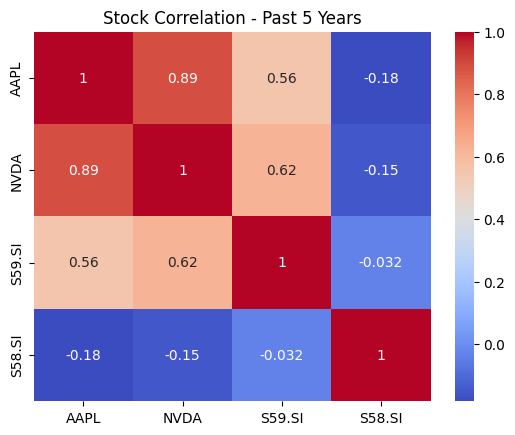

In [83]:
sns.heatmap(corr_5_years, annot=True, cmap="coolwarm")
plt.title("Stock Correlation - Past 5 Years")
plt.show()

## Feature Generation

In [84]:
print(all_daily_stock_data['S59.SI']['Close'].rolling(window=5).mean().tail())
print(all_intraday_stock_data['S59.SI']['Close'].rolling(window=5).mean().tail())

for stock in Stock_List:
    all_daily_stock_data[stock]['MA5'] = all_daily_stock_data[stock]['Close'].rolling(window=5).mean()
    all_daily_stock_data[stock]['MA20'] = all_daily_stock_data[stock]['Close'].rolling(window=20).mean()
    all_daily_stock_data[stock]['Return'] = all_daily_stock_data[stock]['Adj Close'].pct_change()
    all_daily_stock_data[stock]['Volatility'] = all_daily_stock_data[stock]['Return'].rolling(window=5).std()
    all_daily_stock_data[stock] = all_daily_stock_data[stock].dropna().reset_index(drop=True) 
    print(all_daily_stock_data[stock].head())
    
    


1253    3.524
1254    3.534
1255    3.574
1256    3.600
1257    3.590
Name: Close, dtype: float64
2580    3.516
2581    3.516
2582    3.514
2583    3.514
2584    3.516
Name: Close, dtype: float64
        Date        Open        High         Low       Close   Adj Close  \
0 2020-11-06  118.320000  119.199997  116.129997  118.690002  115.651062   
1 2020-11-09  120.500000  121.989998  116.050003  116.320000  113.341728   
2 2020-11-10  115.550003  117.589996  114.129997  115.970001  113.000717   
3 2020-11-11  117.190002  119.629997  116.440002  119.489998  116.430557   
4 2020-11-12  119.620003  120.529999  118.570000  119.209999  116.157745   

      Volume         MA5      MA20    Return  Volatility  
0  114457900  114.375999  116.3240 -0.001136    0.019718  
1  154515300  115.886000  115.9200 -0.019968    0.025332  
2  138023400  116.992000  115.6635 -0.003009    0.026416  
3  112295000  117.900000  115.5785  0.030352    0.023674  
4  103162300  117.936000  115.5035 -0.002343    0.01

In [85]:
all_daily_stock_data['S58.SI'].info()
all_daily_stock_data['S58.SI'].tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1239 entries, 0 to 1238
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1239 non-null   datetime64[ns]
 1   Open        1239 non-null   float64       
 2   High        1239 non-null   float64       
 3   Low         1239 non-null   float64       
 4   Close       1239 non-null   float64       
 5   Adj Close   1239 non-null   float64       
 6   Volume      1239 non-null   int64         
 7   MA5         1239 non-null   float64       
 8   MA20        1239 non-null   float64       
 9   Return      1239 non-null   float64       
 10  Volatility  1239 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 106.6 KB


,Date,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,Return,Volatility
1234,2025-10-06,3.52,3.53,3.49,3.52,3.52,2716300,3.478,3.3530,-0.002833,0.008903
1235,2025-10-07,3.52,3.53,3.48,3.51,3.51,4529600,3.502,3.3650,-0.002841,0.009574
1236,2025-10-08,3.51,3.56,3.51,3.53,3.53,4223000,3.518,3.3785,0.005698,0.007508
1237,2025-10-09,3.53,3.60,3.53,3.58,3.58,5054400,3.534,3.3950,0.014164,0.007400
1238,2025-10-10,3.57,3.57,3.51,3.51,3.51,2829800,3.530,3.4075,-0.019553,0.012508


Step 3B — RSI (Relative Strength Index) + Lag Features

📈 1️⃣ RSI (Relative Strength Index)

RSI measures how strongly prices have moved up vs down in the past n days (usually 14).
Values:

Above 70 → Overbought (might fall)

Below 30 → Oversold (might rise)

Here’s a simple implementation (no extra libraries needed):

In [86]:
for stock in Stock_List:
    #ensure chronological order
    all_daily_stock_data[stock] = all_daily_stock_data[stock].sort_values("Date").reset_index(drop=True)
    # RSI(relative Strength Index)
    window_length = 14
    
    #compute price difference
    delta = all_daily_stock_data[stock]['Adj Close'].diff()
    
    #seperate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    #compute rolling averages
    avg_gain = gain.rolling(window=window_length).mean()
    avg_loss = loss.rolling(window=window_length).mean()
    
    #calculate RS and RSI
    rs = avg_gain / avg_loss
    all_daily_stock_data[stock]['RSI'] = 100 - (100 / (1 + rs))
    # Step 3B — Lag Features (previous day values)
    all_daily_stock_data[stock]["Lag1_Close"] = all_daily_stock_data[stock]["Adj Close"].shift(1)
    all_daily_stock_data[stock]["Lag1_Return"] = all_daily_stock_data[stock]["Return"].shift(1)
    all_daily_stock_data[stock]["Lag2_Return"] = all_daily_stock_data[stock]["Return"].shift(2)
    all_daily_stock_data[stock] = all_daily_stock_data[stock].dropna().reset_index(drop=True)
    
    #creating Target variable for next day close
    all_daily_stock_data[stock]['Target'] = all_daily_stock_data[stock]['Adj Close'].shift(-1)
    all_daily_stock_data[stock] = all_daily_stock_data[stock].dropna().reset_index(drop=True)
    print(all_daily_stock_data[stock].head())
    
    
    

        Date        Open        High         Low       Close   Adj Close  \
0 2020-11-25  115.550003  116.750000  115.169998  116.029999  113.059166   
1 2020-11-27  116.570000  117.489998  116.220001  116.589996  113.604828   
2 2020-11-30  116.970001  120.970001  116.809998  119.050003  116.001839   
3 2020-12-01  121.010002  123.470001  120.010002  122.720001  119.577866   
4 2020-12-02  122.019997  123.370003  120.889999  123.080002  119.928650   

      Volume         MA5        MA20    Return  Volatility        RSI  \
0   76499200  116.205998  116.252999  0.007467    0.017083  42.382544   
1   46691300  115.795998  116.316499  0.004826    0.017041  44.173106   
2  169410200  116.137999  116.825999  0.021100    0.019344  57.537342   
3  127728200  117.912000  117.523500  0.030827    0.010717  65.748952   
4   89004200  119.494000  118.155500  0.002934    0.012054  59.824905   

   Lag1_Close  Lag1_Return  Lag2_Return      Target  
0  112.221191     0.011594    -0.029743  113.60482

## Machine Learning and predicitng

In [87]:
#importing of Libraries
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score

AAPL - RMSE: 12.25, R²: 0.55


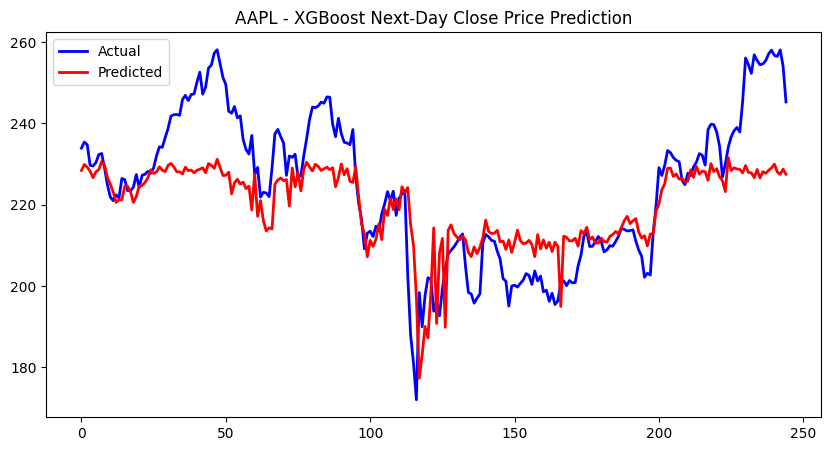

<Figure size 800x600 with 0 Axes>

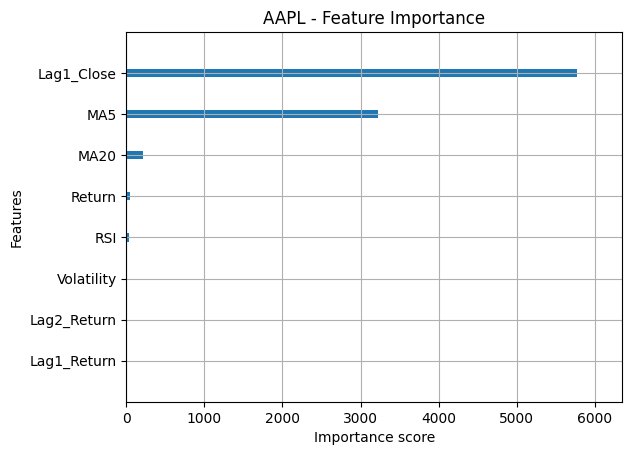

NVDA - RMSE: 25.85, R²: -0.13


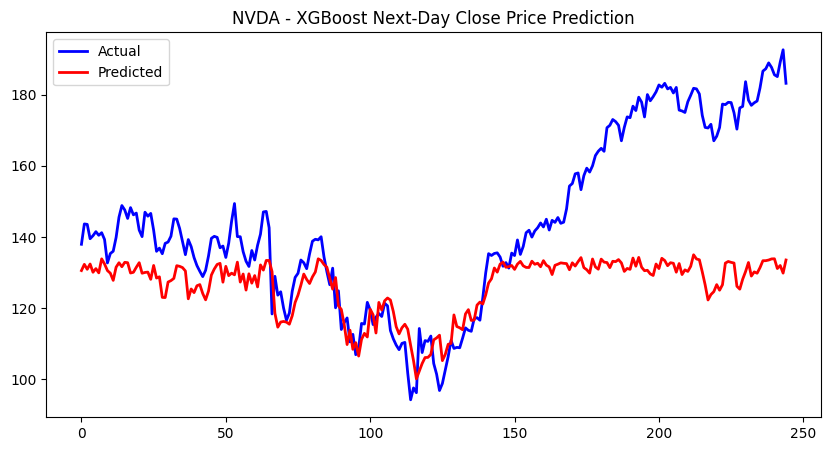

<Figure size 800x600 with 0 Axes>

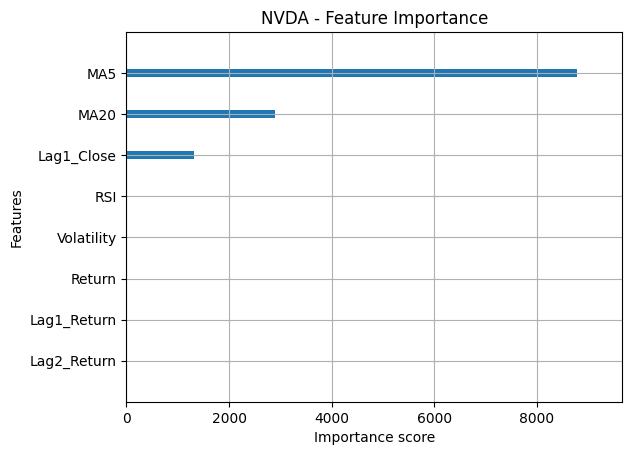

S59.SI - RMSE: 0.49, R²: -0.19


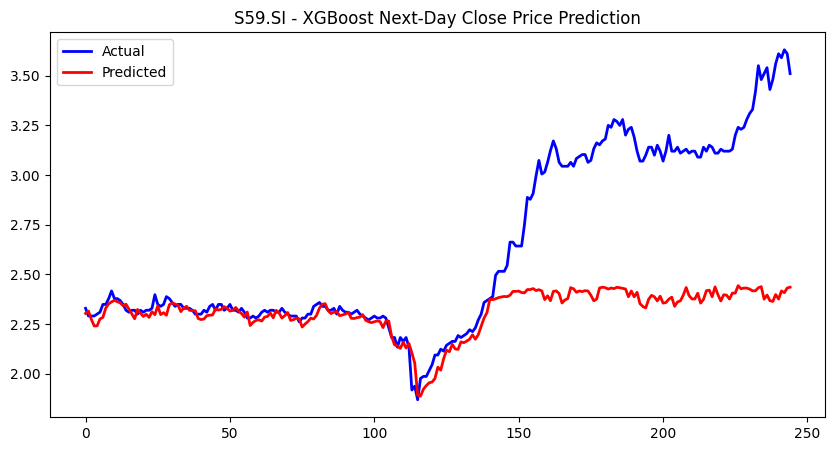

<Figure size 800x600 with 0 Axes>

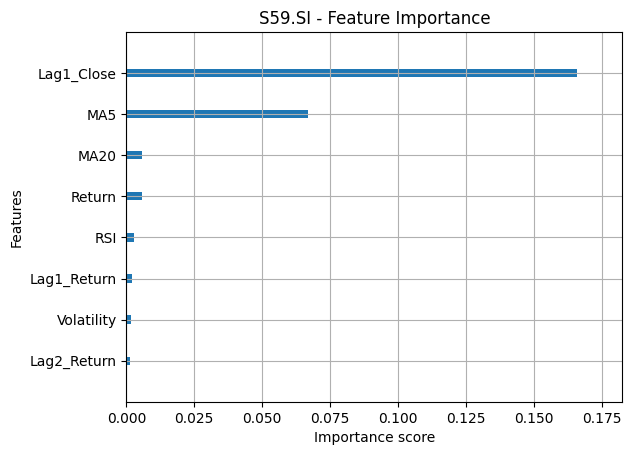

S58.SI - RMSE: 0.07, R²: 0.95


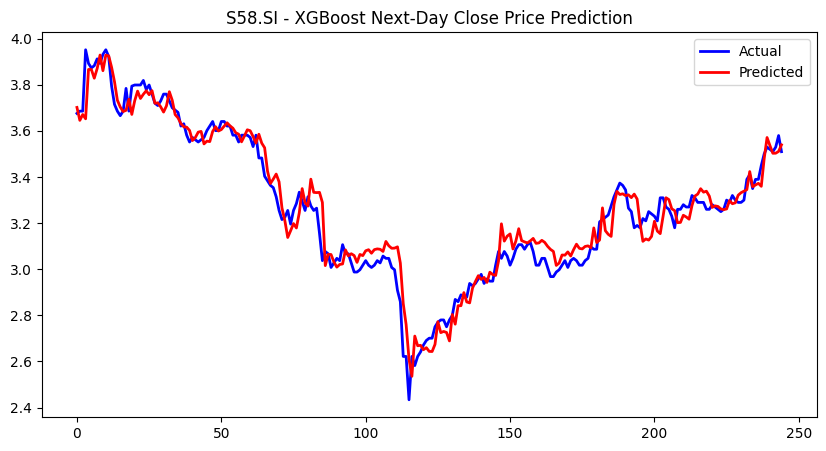

<Figure size 800x600 with 0 Axes>

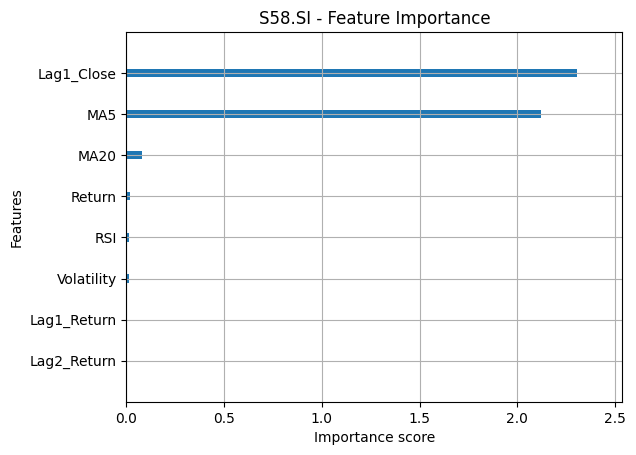

In [88]:
for stock in Stock_List:
    feature_columns = ['MA5', 'MA20', 'Return', 'Volatility', 'RSI',
                       'Lag1_Close', 'Lag1_Return', 'Lag2_Return']
    X = all_daily_stock_data[stock][feature_columns]
    y = all_daily_stock_data[stock]['Target']

    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Safety check
    if len(X_test) == 0 or len(y_test) == 0:
        print(f"⚠️ Skipping {stock} — not enough data for test set ({len(X)} total rows).")
        continue

    model = XGBRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{stock} - RMSE: {rmse:.2f}, R²: {r2:.2f}")

    plt.figure(figsize=(10,5))
    plt.plot(y_test.values, label='Actual', color='blue', linewidth=2)
    plt.plot(y_pred, label='Predicted', color='red', linewidth=2)
    plt.title(f"{stock} - XGBoost Next-Day Close Price Prediction")
    plt.legend()
    plt.show()
    
    #checking feature importance
    plt.figure(figsize=(8,6))
    plot_importance(model, importance_type='gain', show_values=False)
    plt.title(f"{stock} - Feature Importance")
    plt.show()
    

In [94]:

for stock in Stock_List:
    latest_date = all_daily_stock_data[stock]['Date'].iloc[-1]
    next_trading_day = pd.bdate_range(start=latest_date, periods=2)[-1]  # ✅ Skips weekends automatically
    
    latest_features = all_daily_stock_data[stock][feature_columns].iloc[-1]
    
    print(f"\n🔮 Prediction for {stock}:")
    print(f"Last available data: {latest_date.date()}")
    print(f"Predicting for next trading day: {next_trading_day.date()}")
    
    predicted_price = model.predict(latest_features.values.reshape(1, -1))[0]
    
    today_close = all_daily_stock_data[stock]['Adj Close'].iloc[-1]
    diff = predicted_price - today_close
    pct_change = (diff / today_close) * 100
    
    print(f"Today's Close Price: {today_close:.2f}")
    print(f"Predicted Close Price ({next_trading_day.date()}): {predicted_price:.2f}")
    print(f"Expected Change: {diff:+.2f} ({pct_change:+.2f}%)")



🔮 Prediction for AAPL:
Last available data: 2025-10-09
Predicting for next trading day: 2025-10-10
Today's Close Price: 254.04
Predicted Close Price (2025-10-10): 4.22
Expected Change: -249.82 (-98.34%)

🔮 Prediction for NVDA:
Last available data: 2025-10-09
Predicting for next trading day: 2025-10-10
Today's Close Price: 192.57
Predicted Close Price (2025-10-10): 4.24
Expected Change: -188.33 (-97.80%)

🔮 Prediction for S59.SI:
Last available data: 2025-10-09
Predicting for next trading day: 2025-10-10
Today's Close Price: 3.61
Predicted Close Price (2025-10-10): 3.61
Expected Change: +0.00 (+0.00%)

🔮 Prediction for S58.SI:
Last available data: 2025-10-09
Predicting for next trading day: 2025-10-10
Today's Close Price: 3.58
Predicted Close Price (2025-10-10): 3.54
Expected Change: -0.04 (-1.13%)


In [95]:
import pandas as pd

for stock in Stock_List:
    df = all_daily_stock_data[stock]
    df = df.sort_values("Date").reset_index(drop=True)

    last_date = df["Date"].iloc[-1]                # e.g. 2025-10-10 (Friday)
    next_trading_day = pd.bdate_range(start=last_date, periods=2)[-1]  # -> Monday 2025-10-13

    # Use the last available day (Friday) to predict Monday
    latest_features = df[feature_columns].iloc[-1]

    predicted_price = model.predict(latest_features.values.reshape(1, -1))[0]
    today_close = df["Adj Close"].iloc[-1]

    diff = predicted_price - today_close
    pct_change = (diff / today_close) * 100

    print(f"\n🔮 Prediction for {stock}:")
    print(f"Last available data: {last_date.date()}")
    print(f"Predicting for next trading day: {next_trading_day.date()}")
    print(f"Today's Close Price: {today_close:.2f}")
    print(f"Predicted Close Price ({next_trading_day.date()}): {predicted_price:.2f}")
    print(f"Expected Change: {diff:+.2f} ({pct_change:+.2f}%)")



🔮 Prediction for AAPL:
Last available data: 2025-10-09
Predicting for next trading day: 2025-10-10
Today's Close Price: 254.04
Predicted Close Price (2025-10-10): 4.22
Expected Change: -249.82 (-98.34%)

🔮 Prediction for NVDA:
Last available data: 2025-10-09
Predicting for next trading day: 2025-10-10
Today's Close Price: 192.57
Predicted Close Price (2025-10-10): 4.24
Expected Change: -188.33 (-97.80%)

🔮 Prediction for S59.SI:
Last available data: 2025-10-09
Predicting for next trading day: 2025-10-10
Today's Close Price: 3.61
Predicted Close Price (2025-10-10): 3.61
Expected Change: +0.00 (+0.00%)

🔮 Prediction for S58.SI:
Last available data: 2025-10-09
Predicting for next trading day: 2025-10-10
Today's Close Price: 3.58
Predicted Close Price (2025-10-10): 3.54
Expected Change: -0.04 (-1.13%)


In [96]:
def compute_features(df):
    df = df.sort_values("Date").reset_index(drop=True)
    df["Return"] = df["Adj Close"].pct_change()
    df["MA5"] = df["Adj Close"].rolling(5).mean()
    df["MA20"] = df["Adj Close"].rolling(20).mean()
    df["Volatility"] = df["Return"].rolling(5).std()

    # RSI
    window_length = 14
    delta = df["Adj Close"].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window_length).mean()
    avg_loss = loss.rolling(window_length).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # Lag features
    df["Lag1_Close"] = df["Adj Close"].shift(1)
    df["Lag1_Return"] = df["Return"].shift(1)
    df["Lag2_Return"] = df["Return"].shift(2)

    df = df.dropna().reset_index(drop=True)
    return df


In [99]:
import pandas as pd

for stock in Stock_List:
    try:
        # --- Load latest daily data ---
        file_path = project_folder / f"{stock}_data_daily.csv"
        df = pd.read_csv(file_path)
        df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])
        df = df.drop(["Year", "Month", "Day"], axis=1)
        df = compute_features(df)

        # --- Prepare for prediction ---
        latest_features = df[feature_columns].iloc[-1]
        today_close = df["Adj Close"].iloc[-1]
        today_date = df["Date"].iloc[-1]
        next_trading_day = pd.bdate_range(start=today_date, periods=2)[-1]

        # --- Predict ---
        predicted_price = model.predict(latest_features.values.reshape(1, -1))[0]
        diff = predicted_price - today_close
        pct_change = (diff / today_close) * 100

        # --- Print result ---
        print(f"\n🔮 Prediction for {stock}:")
        print(f"Last available data: {today_date.date()}")
        print(f"Last Day's Close Price: {today_close:.2f}")
        print(f"Predicting for next trading day: {next_trading_day.date()}")
        print(f"Predicted Close Price ({next_trading_day.date()}): {predicted_price:.2f}")
        print(f"Expected Change: {diff:+.2f} ({pct_change:+.2f}%)")

    except Exception as e:
        print(f"\n⚠️ Skipped {stock} due to error: {e}")



🔮 Prediction for AAPL:
Last available data: 2025-10-10
Last Day's Close Price: 245.27
Predicting for next trading day: 2025-10-13
Predicted Close Price (2025-10-13): 4.10
Expected Change: -241.17 (-98.33%)

🔮 Prediction for NVDA:
Last available data: 2025-10-10
Last Day's Close Price: 183.16
Predicting for next trading day: 2025-10-13
Predicted Close Price (2025-10-13): 4.08
Expected Change: -179.08 (-97.77%)

🔮 Prediction for S59.SI:
Last available data: 2025-10-10
Last Day's Close Price: 3.51
Predicting for next trading day: 2025-10-13
Predicted Close Price (2025-10-13): 3.58
Expected Change: +0.07 (+2.03%)

🔮 Prediction for S58.SI:
Last available data: 2025-10-10
Last Day's Close Price: 3.51
Predicting for next trading day: 2025-10-13
Predicted Close Price (2025-10-13): 3.52
Expected Change: +0.01 (+0.18%)
